# Movie Recommendation System Based on Spark 


In [1]:
from csv import reader

movies = sc.textFile('ml-latest-small/movies.csv')
ratings = sc.textFile("ml-latest-small/ratings.csv")
links = sc.textFile("ml-latest-small/links.csv")
tags = sc.textFile("ml-latest-small/tags.csv")


## Q1. How many users


In [2]:
def clean(rdd):
    rdd = rdd.map(lambda line: line.split(','))
    header = rdd.first()
    rdd = rdd.filter(lambda x: x!=header)
    return rdd

ratings = clean(ratings)
user = ratings.map(lambda x: (x[0],1))
from operator import add
sorted(user.reduceByKey(add).collect(), key = lambda x: int(x[0]))

from pyspark.sql import Row

ratings.collect()
ratings_dict = ratings.map(lambda item: Row(user_id=item[0],movie_id=item[1],rating=item[2], timestamp = item[3]))
ratings_df = spark.createDataFrame(ratings_dict)
ratings_df.createOrReplaceTempView("ratings_sql")


#### So there are 671 users in total

## Q2. How many movies

In [3]:
movies = clean(movies)
movies.count()

9125

#### So there are 9125 movies

In [4]:
from pyspark.sql import Row

movies_dict = movies.map(lambda item:Row(movie_id=item[0],name=item[1],genres=item[2]))
movies_df = spark.createDataFrame(movies_dict)
movies_df.createOrReplaceTempView("movies_sql")

# Q3. How many movies are rated by users? List movies that are not read before

In [5]:
ratings.collect()
ratings_movies = ratings.map(lambda x: (x[1],1))
ratings_movies = ratings_movies.reduceByKey(add)
num = ratings_movies.count()
num 

9066

#### So there are 9066 movies rated by users

In [6]:
not_rated_id = spark.sql("(SELECT movies_sql.movie_id AS movie_id FROM movies_sql)\
EXCEPT (SELECT movie_id FROM ratings_sql)")
not_rated_id.createOrReplaceTempView("not_rated_id")
not_rated = spark.sql("SELECT movies_sql.name AS name, movies_sql.movie_id AS movie_id FROM movies_sql\
, not_rated_id WHERE movies_sql.movie_id = not_rated_id.movie_id")
not_rated.show()

+--------------------+--------+
|                name|movie_id|
+--------------------+--------+
|     February (2015)|  144172|
|      Kahaani (2012)|   94969|
|A Girl Like Her (...|  132547|
|Pickup on South S...|    7335|
|             "Rocket|  110871|
|Woman in Gold (2015)|  131796|
|         "Story of O|    5984|
|Welcome to Me (2014)|  132800|
|Stormy Weather (1...|  128235|
|After School Spec...|   39421|
|    Nightfall (1957)|   82313|
|          "Immigrant|  111251|
|      Grandma (2015)|  132549|
|Late Spring (Bans...|   42217|
|          "Big Clock|    8767|
|Hell or High Wate...|  161582|
|The Neon Demon (2...|  155064|
|        Belle (2013)|  111249|
|Facing the Giants...|   48711|
|Monkey Kingdom (2...|  132458|
+--------------------+--------+
only showing top 20 rows



# Q4. List movies genres & Q5. Compute num of movies for each category

In [7]:
movies_genres = movies.flatMap(lambda x: x[len(x)-1].split('|'))
movies_genres = movies_genres.map(lambda x: (x,1))
movies_genres = movies_genres.reduceByKey(add)
movies_genres.collect()

[(u'Mystery', 543),
 (u'Romance', 1545),
 (u'Horror', 877),
 (u'Film-Noir', 133),
 (u'Drama', 4365),
 (u'Action', 1545),
 (u'Documentary', 495),
 (u'Thriller', 1729),
 (u'IMAX', 153),
 (u'Sci-Fi', 792),
 (u'Crime', 1100),
 (u'Fantasy', 654),
 (u'Animation', 447),
 (u'War', 367),
 (u'Western', 168),
 (u'Children', 583),
 (u'(no genres listed)', 18),
 (u'Comedy', 3315),
 (u'Musical', 394),
 (u'Adventure', 1117)]

# ALS Algorithm in Spark


In [8]:
from pyspark.mllib.recommendation import ALS, MatrixFactorizationModel, Rating

ratings = ratings.map(lambda l: Rating(int(l[0]), int(l[1]), float(l[2])))
ratings.collect()
res = []

def train(ratings, rank, iteration, lamb):
    model = ALS.train(ratings, rank, iteration, lamb)
    testdata = ratings.map(lambda p: (p[0], p[1]))
    predictions = model.predictAll(testdata).map(lambda r: ((r[0], r[1]), r[2]))
    ratesAndPreds = ratings.map(lambda r: ((r[0], r[1]), r[2])).join(predictions)
    MSE = ratesAndPreds.map(lambda r: (r[1][0] - r[1][1])**2).mean()
    res.append((rank, iteration, lamb, MSE))
    print("For rank, iteration, lambda are {},{},{}".format(str(rank), str(iteration), str(lamb))+", mean squared error = " + str(MSE))
    return (MSE,model)



In [9]:
rank_set = [5,8,10,15]
iteration_set=[10,20]
lamb_set = [0.01,0.02,0.05,0.1,0.2,0.3]
best_rank, best_iteration, best_lamb, best_MSE, best_model = 0, 0, 0, float('inf'), None

import time
start_time = time.time()

for i in iteration_set:
    for j in rank_set:
        for k in lamb_set:
            temp = train(ratings, j, i, k)
            if temp[0]<best_MSE:
                best_MSE,best_rank, best_iteration, best_lamb, best_model = temp[0],j, i, k, temp[1]
print'Best hyperparam set(rank, iteration, lambda) is'+str(best_rank)+','+str(best_iteration)+','+str(best_lamb)+'.'+'And corresponding MSE is'+str(best_MSE)
print 'Total Runtime: '+str(time.time() - start_time)+'seconds'

For rank, iteration, lambda are 5,10,0.01, mean squared error = 0.411765202263
For rank, iteration, lambda are 5,10,0.02, mean squared error = 0.418253480644
For rank, iteration, lambda are 5,10,0.05, mean squared error = 0.420958917278
For rank, iteration, lambda are 5,10,0.1, mean squared error = 0.461356882407
For rank, iteration, lambda are 5,10,0.2, mean squared error = 0.5799728772
For rank, iteration, lambda are 5,10,0.3, mean squared error = 0.717709695671
For rank, iteration, lambda are 8,10,0.01, mean squared error = 0.318216534649
For rank, iteration, lambda are 8,10,0.02, mean squared error = 0.320177688635
For rank, iteration, lambda are 8,10,0.05, mean squared error = 0.341092522376
For rank, iteration, lambda are 8,10,0.1, mean squared error = 0.401001676808
For rank, iteration, lambda are 8,10,0.2, mean squared error = 0.564548985147
For rank, iteration, lambda are 8,10,0.3, mean squared error = 0.709248814842
For rank, iteration, lambda are 10,10,0.01, mean squared err

## For each user, recommend two movies

In [10]:
recommend_user = best_model.recommendProductsForUsers(2)
recommend_user = recommend_user.map(lambda x: (x[0], x[1][0][1], x[1][1][1]))
recommend_user.collect()
recommend_user_dict = recommend_user.map(lambda item:Row(user_id=item[0],recommend_movie1=item[1],recommend_movie2=item[2]))
recommend_user_df = spark.createDataFrame(recommend_user_dict )
recommend_user_df.createOrReplaceTempView("recommend_user")
reco1_res= spark.sql("(SELECT recommend_user.user_id,movies_sql.name AS recommend_1 \
FROM recommend_user INNER JOIN movies_sql ON recommend_user.recommend_movie1 = movies_sql.movie_id) \
")
reco1_res.createOrReplaceTempView("reco1_res")
reco2_res= spark.sql("(SELECT recommend_user.user_id,movies_sql.name AS recommend_2 \
FROM recommend_user INNER JOIN movies_sql ON recommend_user.recommend_movie2 = movies_sql.movie_id) \
")
reco2_res.createOrReplaceTempView("reco2_res")
reco_res = spark.sql("SELECT reco1_res.user_id,reco1_res.recommend_1 AS recommend_1,reco2_res.recommend_2 \
FROM reco1_res INNER JOIN reco2_res ON reco1_res.user_id = reco2_res.user_id ORDER BY reco1_res.user_id ")
reco_res.show()

+-------+--------------------+--------------------+
|user_id|         recommend_1|         recommend_2|
+-------+--------------------+--------------------+
|      1|              "Score|    Westworld (1973)|
|      2|"Aguirre: The Wra...|      "Lawnmower Man|
|      3|     "Bone Collector|             "Jackal|
|      4|       Baraka (1992)| "Fistful of Dollars|
|      5|      Tangled (2010)|Freaky Friday (2003)|
|      6|American Sniper (...|        Benji (1974)|
|      7|"Aguirre: The Wra...|              "Piano|
|      8|The Fault in Our ...|"Adventures of Ba...|
|      9|         "Dolce Vita|Dancer in the Dar...|
|     10|    "Lives of Others|       Hamlet (1996)|
|     11|         "Ninth Gate|      Tangled (2010)|
|     12|Fantasia 2000 (1999)|Mad Max: Fury Roa...|
|     13|Resident Evil: Ap...|Dirty Rotten Scou...|
|     14|"Emperor's New Gr...|Dancer in the Dar...|
|     15|   Dick Tracy (1990)|"Best Years of Ou...|
|     16|Micmacs (Micmacs ...|        Crumb (1994)|
|     17|Onc

# MSE curves


#### When iteration time is 10

In [11]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

In [12]:
# res.append((rank, iteration, lamb, MSE))

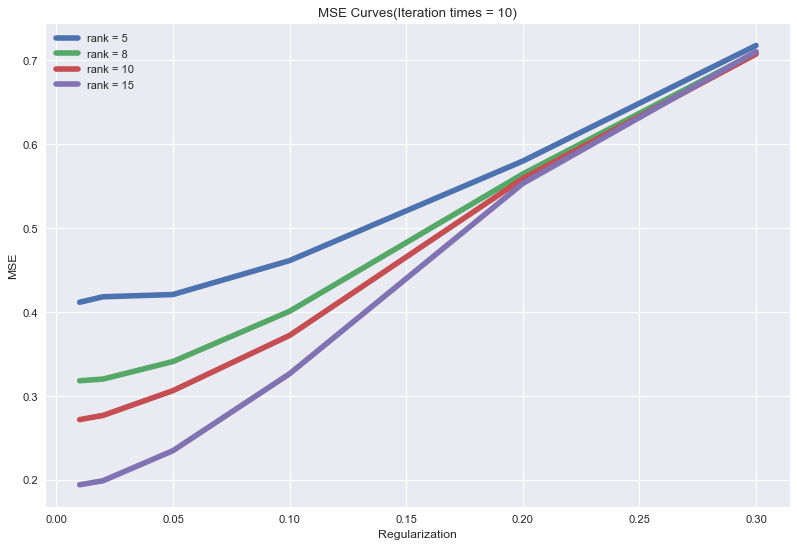

In [13]:
res = filter(lambda x: x[1]==10, res)
def generate(list, start,end):
    reg,error  = [],[]
    for i in range(start, end+1):
        reg.append(list[i][2])
        error.append(list[i][3])
    return(reg,error)
x_5,y_5 = generate(res, 0, 5)[0],generate(res, 0, 5)[1]
x_8,y_8 = generate(res, 6, 11)[0],generate(res,6,11)[1]
x_10,y_10 = generate(res, 12, 17)[0],generate(res,12,17)[1]
x_15,y_15 = generate(res, 18, 23)[0],generate(res,18,23)[1]

plt.figure(figsize=(12, 8), dpi=80)
ax = plt.subplot(111)
ax.plot(x_5,y_5,label='rank = 5',linewidth=5)
ax.plot(x_8,y_8,label='rank = 8',linewidth=5)
ax.plot(x_10,y_10,label='rank = 10',linewidth=5)
ax.plot(x_15,y_15,label='rank = 15',linewidth=5)
plt.xlabel('Regularization')
plt.ylabel('MSE')
plt.title('MSE Curves(Iteration times = 10)')
ax.legend(numpoints=1, loc = 2)
plt.show()